In [2]:
# Imports
from os import makedirs
from os.path import join
import pickle
import numpy as np
rng_seed = 399
np.random.seed(rng_seed)
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.auto import tqdm
import sys
sys.path.append("..")

from hdbscan import HDBSCAN

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import pairwise_distances
from scipy.cluster.hierarchy import dendrogram, fcluster

from umap import UMAP
import plotly.offline as pyo
pyo.init_notebook_mode()

from utils import get_model_checkpoint_filepaths, pairwise_cosine_distances
from analysis_utils import create_linkage_matrix, words_in_clusters, plot_silhouette_scores
from word_embeddings.eval_utils import plot_word_vectors

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [3]:
# Get last word embeddings from training
checkpoint_filepaths_dict = get_model_checkpoint_filepaths(
    output_dir="../output/word2vec_training/03-Nov-2020_11-01-00",
    model_name="word2vec",
    dataset_name="enwiki",
)
last_embedding_weights_filepath = checkpoint_filepaths_dict["intermediate_embedding_weight_filepaths"][-1]
last_embedding_weights = np.load(last_embedding_weights_filepath, mmap_mode="r").astype(np.float64)

In [4]:
# Load words and create word to int lookup dict
with open(checkpoint_filepaths_dict["train_words_filepath"], "r") as file:
    words = np.array(file.read().split("\n"))
word_to_int = {word: i for i, word in enumerate(words)}
vocab_size = 10000

In [6]:
# Precompute cosine distance matrix
word_embeddings_to_precompute = last_embedding_weights[:vocab_size]
word_embeddings_distances = pairwise_cosine_distances(word_embeddings_to_precompute)

In [24]:
# Perform clustering with HDBSCAN
hdbscan_param_grid = ParameterGrid({
    "core_dist_n_jobs": [-1],
    "min_cluster_size": [2, 4, 8, 16, 32, 64, 128, 256], 
    "min_samples": [1, 2, 4, 8, 16, 32, 64, 128, 256],
    "metric": ["precomputed"]
})
hdbscan_cluster_labels = []
hdbscan_silhouette_scores = []
for param_grid in tqdm(hdbscan_param_grid, desc="Performing HDBSCAN clustering"):
    hdbscan_clustering = HDBSCAN(**param_grid)
    cluster_labels_pred = hdbscan_clustering.fit_predict(word_embeddings_distances)
    
    num_clusters = len(np.unique(cluster_labels_pred))
    print(f"Number of clusters: {num_clusters}")
    
    hdbscan_cluster_labels.append(cluster_labels)
    sil_score = silhouette_score(word_embeddings_distances, cluster_labels_pred, metric="precomputed")
    hdbscan_silhouette_scores.append(sil_score)

Number of clusters: 2527
Number of clusters: 1108
Number of clusters: 523
Number of clusters: 206
Number of clusters: 82
Number of clusters: 3
Number of clusters: 3
Number of clusters: 3
Number of clusters: 3
Number of clusters: 778
Number of clusters: 558
Number of clusters: 206
Number of clusters: 81
Number of clusters: 36
Number of clusters: 16
Number of clusters: 8
Number of clusters: 3
Number of clusters: 3
Number of clusters: 267
Number of clusters: 193
Number of clusters: 93
Number of clusters: 47
Number of clusters: 23
Number of clusters: 13
Number of clusters: 4
Number of clusters: 3
Number of clusters: 3
Number of clusters: 97
Number of clusters: 68
Number of clusters: 42
Number of clusters: 29
Number of clusters: 15
Number of clusters: 7
Number of clusters: 3
Number of clusters: 3
Number of clusters: 3
Number of clusters: 30
Number of clusters: 24
Number of clusters: 21
Number of clusters: 14
Number of clusters: 10
Number of clusters: 5
Number of clusters: 3
Number of cluste

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

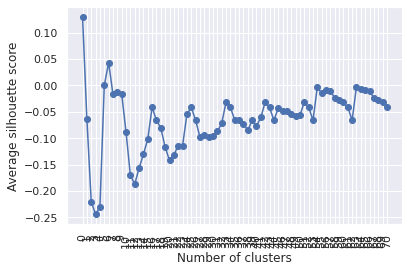

In [14]:
plot_silhouette_scores(range(len(hdbscan_param_grid)), hdbscan_silhouette_scores)

In [39]:
best_clusters_idx = np.argmax(hdbscan_silhouette_scores)
best_cluster_labels = hdbscan_cluster_labels[best_clusters_idx]
best_cluster_labels_no_noise_mask = best_cluster_labels != -1
best_cluster_labels_no_noise = best_cluster_labels[best_cluster_labels_no_noise_mask]

In [55]:
word_embeddings_transformed = UMAP(
    n_components=2, metric="precomputed"
).fit_transform(word_embeddings_distances)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



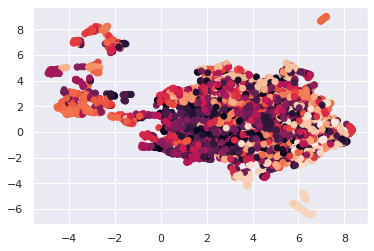

In [62]:
plt.scatter(
    word_embeddings_transformed[:, 0][best_cluster_labels_no_noise_mask],
    word_embeddings_transformed[:, 1][best_cluster_labels_no_noise_mask],
    c=best_cluster_labels_no_noise
)

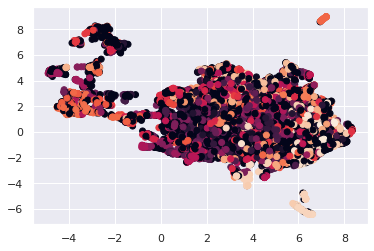

In [64]:
plt.scatter(
    word_embeddings_transformed[:, 0],
    word_embeddings_transformed[:, 1],
    c=best_cluster_labels
)

In [56]:
plot_word_vectors(
    words_to_plot=words[:vocab_size][best_cluster_labels_no_noise_mask],
    transformed_word_embeddings=word_embeddings_transformed,
    word_to_int=word_to_int,
    word_colors=best_cluster_labels_no_noise
)

In [6]:
def agglomerative_cluster_number_search(
    cluster_numbers: list,
    clusterings: list,
    linkages: list,
    word_embeddings_distances: np.ndarray,
    output_filepath_suffix: str,
    output_dir: str = None,
    model_name: str = None,
    dataset_name: str = None
) -> None:
    """
    TODO: Docs
    """
    # Ensure output directory exists
    makedirs(output_dir, exist_ok=True)

    # Fit and predict cluster labels
    cluster_labels = {}
    print(f"-- Fitting and predicting cluster labels for agglomerative clustering --")
    for linkage in linkages:
        print(f"Linkage: {linkage}")
        cluster_labels[linkage] = {
            "labels": [],
            "metric_values": [],
            "best_labels_idx": -1
        }
        for k in tqdm(cluster_numbers):

            linkage_matrix = clusterings[linkage]["linkage_matrix"]
            cluster_labels_pred = fcluster(Z=linkage_matrix, criterion="maxclust", t=k)
            cluster_labels[linkage]["labels"].append(cluster_labels_pred)

            cluster_metric_value = silhouette_score(word_embeddings_distances, cluster_labels_pred, metric="precomputed")
            cluster_labels[linkage]["metric_values"].append(cluster_metric_value)

        cluster_labels[linkage]["best_labels_idx"] = np.argmax(cluster_labels[linkage]["metric_values"])

    # Save to output dir
    if output_dir is not None and model_name is not None and dataset_name is not None:
        output_path = join(output_dir, f"{model_name}-{dataset_name}-{output_filepath_suffix}.pkl")
        with open(output_path, "wb") as file:
            pickle.dump(cluster_labels, file)
    
    return cluster_labels

In [7]:
should_pred_cluster_labels = False
ks = [2, 3, 4, 5, 10, 50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
if should_pred_cluster_labels:
    pred_cluster_labels = agglomerative_cluster_number_search(
        cluster_numbers=ks,
        clusterings=agglomerative_clusterings,
        linkages=list(agglomerative_clusterings.keys()),
        word_embeddings_distances=word_embeddings_distances,
        output_filepath_suffix="agglomerative_labels",
        output_dir="../output/word2vec_cluster_analysis",
        model_name="word2vec",
        dataset_name="enwiki"
    )
else:
    with open("../output/word2vec_cluster_analysis/word2vec-enwiki-agglomerative_labels.pkl", "rb") as file:
        pred_cluster_labels = pickle.load(file)

Linkage: complete


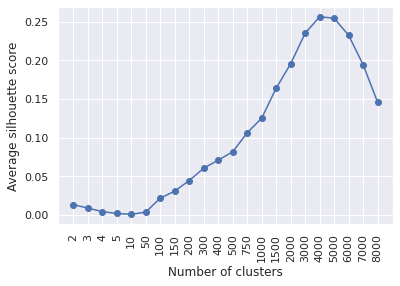

Linkage: average


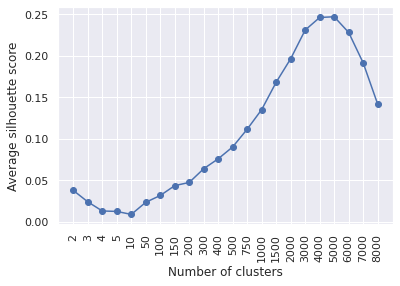

Linkage: single


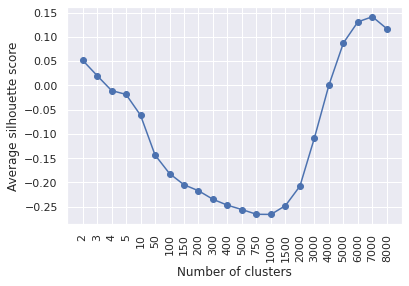

In [8]:
for linkage in agglomerative_clusterings.keys():
    print(f"Linkage: {linkage}")
    plot_silhouette_scores(ks, pred_cluster_labels[linkage]["metric_values"])

In [9]:
# Zoom in at 3000-6000 clusters.
should_pred_cluster_labels_zoomed = False
ks_zoomed = np.linspace(3000, 6000, num=100, dtype=int)
if should_pred_cluster_labels_zoomed:
    pred_cluster_labels_zoomed = agglomerative_cluster_number_search(
        cluster_numbers=ks_zoomed,
        clusterings=agglomerative_clusterings,
        linkages=["complete", "average"],
        word_embeddings_distances=word_embeddings_distances,
        output_filepath_suffix="agglomerative_labels_zoomed",
        output_dir="../output/word2vec_cluster_analysis",
        model_name="word2vec",
        dataset_name="enwiki"
    )
else:
    with open("../output/word2vec_cluster_analysis/word2vec-enwiki-agglomerative_labels_zoomed.pkl", "rb") as file:
        pred_cluster_labels_zoomed = pickle.load(file)

Linkage: complete
Best number of clusters: 4303


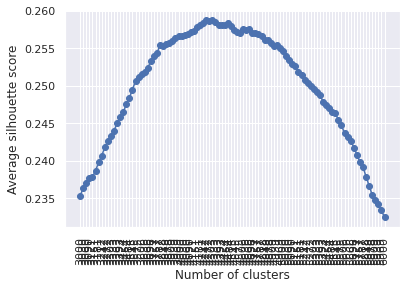

Linkage: average
Best number of clusters: 4484


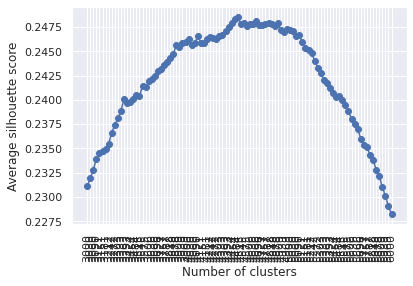

In [10]:
best_cluster_labels = {}
for linkage in ["complete", "average"]:
    print(f"Linkage: {linkage}")
    silhouette_scores = pred_cluster_labels_zoomed[linkage]["metric_values"]
    best_labels_idx = pred_cluster_labels_zoomed[linkage]["best_labels_idx"]
    
    best_num_clusters = ks_zoomed[best_labels_idx]
    print(f"Best number of clusters: {best_num_clusters}")
    
    best_cluster_labels[linkage] = pred_cluster_labels_zoomed[linkage]["labels"][best_labels_idx]
    plot_silhouette_scores(ks_zoomed, silhouette_scores)

Linkage: complete
4303 clusters: max=35, min=1, ratio=35.0


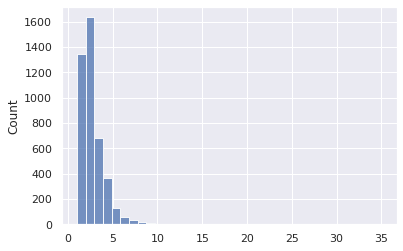

---
Linkage: average
4484 clusters: max=101, min=1, ratio=101.0


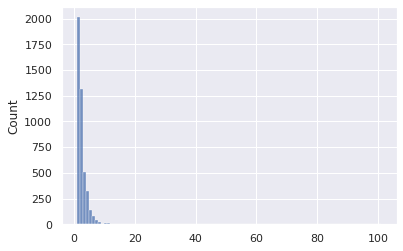

---


In [11]:
# Compute cluster size ratios (maximum cluster size / minimum cluster size)
most_common_cluster_sizes = {}
for linkage, labels in best_cluster_labels.items():
    print(f"Linkage: {linkage}")
    labels_unique, labels_counts = np.unique(labels, return_counts=True)
    num_clusters = len(labels_unique)
    max_cluster_size = max(labels_counts)
    min_cluster_size = min(labels_counts)
    cluster_size_ratio = max_cluster_size / min_cluster_size
    print(f"{num_clusters} clusters: max={max_cluster_size}, min={min_cluster_size}, ratio={cluster_size_ratio}")
    
    # Plot distribution of cluster sizes
    hist_plot = sns.histplot(labels_counts, bins=max_cluster_size)
    bar_heights = [h.get_height() for h in hist_plot.patches]
    most_common_cluster_sizes[linkage] = np.arange(1, max_cluster_size + 1)[np.argsort(bar_heights)[::-1]]
    plt.show()

    print("---")

In [12]:
# Look at the words corresponding to the different clusters (biggest, smallest, etc.)

In [13]:
cluster_words, cluster_sizes = words_in_clusters(
    cluster_labels=best_cluster_labels["complete"],
    words=words[:vocab_size]
)

In [14]:
# Only inspect clusters with at least 5 words in them
min_cluster_size = 5
filter_min_cluster_size_mask = cluster_sizes >= min_cluster_size
cluster_sizes_filtered = cluster_sizes[filter_min_cluster_size_mask]
cluster_words_filtered = cluster_words[filter_min_cluster_size_mask]

In [15]:
sorted_cluster_indices = np.argsort(cluster_sizes_filtered)[::-1]

num_clusters_print = 10
print(f"-- {num_clusters_print} largest clusters --")
for i in range(num_clusters_print):
    print(cluster_words_filtered[sorted_cluster_indices[i]])
    
print(f"-- {num_clusters_print} smallest clusters --")
for i in range(1, num_clusters_print + 1):
    print(cluster_words_filtered[sorted_cluster_indices[-i]])

-- 10 largest clusters --
['forty-five' 'sixty-four' 'sixty-five' 'thirty-five' 'forty-four'
 'sixty-eight' 'forty-two' 'thirty-two' 'forty-eight' 'sixty-seven'
 'sixty-six' 'forty-one' 'sixty-nine' 'fifty-five' 'thirty-six'
 'sixty-two' 'sixty-three' 'thirty-three' 'thirty-nine' 'thirty-eight'
 'forty-seven' 'sixty-one' 'forty-six' 'thirty-seven' 'forty-three'
 'forty-nine' 'fifty-six' 'fifty-two' 'thirty-four' 'fifty-four'
 'fifty-one' 'fifty-eight' 'fifty-nine' 'fifty-seven' 'fifty-three']
['thousand' 'one' 'hundred' 'nine' 'ninety' 'ninety-nine' 'ninety-eight'
 'ninety-five' 'ninety-six' 'ninety-seven' 'ninety-two' 'ninety-four'
 'ninety-three' 'seventy-five' 'ninety-one' 'eighty-nine' 'eighty-five'
 'eighty-eight' 'eighty-six' 'eighty-seven' 'eighty-four' 'eighty-three'
 'eighty-two' 'seventy-two' 'eighty-one' 'seventy-six' 'seventy-nine'
 'seventy-eight' 'seventy-four' 'seventy-seven' 'seventy-one'
 'seventy-three']
['two' 'eight' 'three' 'four' 'five' 'six' 'seven' 'ten' 'twelve

In [16]:
# Inspect words from clusters whose cluster numbers is the most common

In [30]:
for cluster_words in cluster_words[cluster_sizes == most_common_cluster_sizes["complete"][0]][:25]:
    print(cluster_words)

['die' 'dies']
['suicide' 'committed_suicide']
['death' 'dying']
['sick' 'ill']
['died' 'heart_attack']
['illness' 'tuberculosis']
['charlotte' 'caroline']
['wedding' 'bride']
['couple' 'couples']
['pregnant' 'pregnancy']
['birth' 'gave_birth']
['infant' 'infants']
['baby' 'babies']
['quiet' 'calm']
['tone' 'mood']
['spiritual' 'meditation']
['joy' 'happiness']
['silent' 'silence']
['remember' 'forgotten']
['dark' 'darkness']
['shadow' 'shadows']
['mirror' 'reflection']
['reality' 'real_world']
['belief' 'beliefs']
['awareness' 'consciousness']


In [18]:
# Visualizing first 1000 words using UMAP (TODO: remove this?)

In [20]:
word_embeddings_transformed = UMAP(n_components=2, metric="precomputed").fit_transform(word_embeddings_distances)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



In [37]:
plot_word_vectors(
    words_to_plot=words[:1000],
    transformed_word_embeddings=word_embeddings_transformed[:1000],
    word_to_int=word_to_int,
    word_colors=best_cluster_labels["complete"][:1000]
)